In [ ]:
import opendatasets as od

In [ ]:
datadase_url = "https://www.kaggle.com/datasets/inputblackboxoutput/passwordevaluation"
od.download(datadase_url)

In [2]:
import pandas as pd
import numpy as np
from joblib import dump, load
from tqdm import tqdm
import warnings

tqdm.pandas()
warnings.filterwarnings("ignore")

In [ ]:
dataset_path = "./passwordevaluation/dataset.csv"
raw_df = pd.read_csv(dataset_path, encoding="utf-8")
raw_df.head()

In [ ]:
raw_df.columns = ["strength", "password"]
raw_df = raw_df.astype({"strength": int, "password": str})
raw_df.dropna(inplace=True)
raw_df.info()

In [ ]:
df1 = raw_df[~raw_df["password"].str.contains(r"[^\x00-\x7F]")]

In [ ]:
n_ = df1["strength"].value_counts().min()
df2 = df1.groupby("strength").sample(n=n_, random_state=42)
N = n_ * len(df2["strength"].unique())

In [ ]:
df = df2.sample(N,random_state=24)
df.reset_index(drop=True, inplace=True)

In [ ]:
df

In [ ]:
df.to_csv("./database/passwords.csv", index=False)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
batch_size = 100
df_split = np.array_split(df1, batch_size)

In [4]:
dataset_path = "./database/passwords.csv"
df = pd.read_csv(dataset_path, encoding="utf-8")

In [5]:
def createTokens(f):
    return list(f)

In [6]:
vectorizer = TfidfVectorizer(
    tokenizer=createTokens,
    ngram_range=(1, 3),
    min_df=0.0001,
    lowercase=False,
)

In [ ]:
for i in tqdm(range(batch_size)):
    vectorizer.fit(df_split[i]["password"].values.astype("U"))

In [ ]:
dump(vectorizer, "./database/tfidf_password.pkl")

In [6]:
vectorizer = load("./database/tfidf_password.pkl")

In [7]:
analyze = vectorizer.build_analyzer()

In [8]:
analyze

functools.partial(<function _analyze at 0x000001FD9ACFACA0>, ngrams=<bound method _VectorizerMixin._word_ngrams of TfidfVectorizer(lowercase=False, min_df=0.0001, ngram_range=(1, 3),
                tokenizer=<function createTokens at 0x000001FDF952BCA0>)>, tokenizer=<function createTokens at 0x000001FDF952BCA0>, preprocessor=functools.partial(<function _preprocess at 0x000001FD9ACFAC10>, accent_function=None, lower=False), decoder=<bound method _VectorizerMixin.decode of TfidfVectorizer(lowercase=False, min_df=0.0001, ngram_range=(1, 3),
                tokenizer=<function createTokens at 0x000001FDF952BCA0>)>, stop_words=None)

In [9]:
df["password"] = df["password"].values.astype('U')


In [10]:
tokens = df["password"].apply(lambda x: analyze(x))
tokens

0         [u, s, i, n, g, u s, s i, i n, n g, u s i, s i...
1         [s, t, a, c, e, y, 1, 3, 0, 4, 1, 9, 9, 6, s t...
2         [m, c, c, a, f, f, r, e, y, 8, 7, m c, c c, c ...
3         [m, i, t, a, y, a, 2, 0, 0, 3, m i, i t, t a, ...
4         [v, a, y, a, c, o, n, t, i, o, z, v a, a y, y ...
                                ...                        
149360    [a, l, e, x, i, s, g, t, a l, l e, e x, x i, i...
149361    [t, a, i, 0, 0, 7, n, a, k, a, b, t a, a i, i ...
149362    [m, a, t, r, i, c, u, l, a, 1, 9, 6, 2, m a, a...
149363    [p, 3, t, e, r, s, p 3, 3 t, t e, e r, r s, p ...
149364            [i, n, e, z, i n, n e, e z, i n e, n e z]
Name: password, Length: 149365, dtype: object

In [11]:
X = vectorizer.transform(tokens)
y = df["strength"]

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [15]:
import matplotlib.pyplot as plt

In [16]:
def result_model(model):
    print(model)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print(classification_report(y_test, y_predict, target_names=["0", "1", "2", "3", "4"]))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_predict)
    plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [20]:
rfc = RandomForestClassifier(n_jobs=-1)
dfc = DecisionTreeClassifier()
sgd = SGDClassifier()
lsvc = LinearSVC(max_iter=1000000)
per = Perceptron()
knc = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
lr = LogisticRegression(max_iter=1000000)

RandomForestClassifier(n_jobs=-1)
              precision    recall  f1-score   support

           0       0.69      0.92      0.79      8896
           1       0.57      0.45      0.50      8890
           2       0.54      0.47      0.51      9055
           3       0.58      0.52      0.55      8952
           4       0.73      0.82      0.77      9017

    accuracy                           0.64     44810
   macro avg       0.62      0.64      0.62     44810
weighted avg       0.62      0.64      0.62     44810



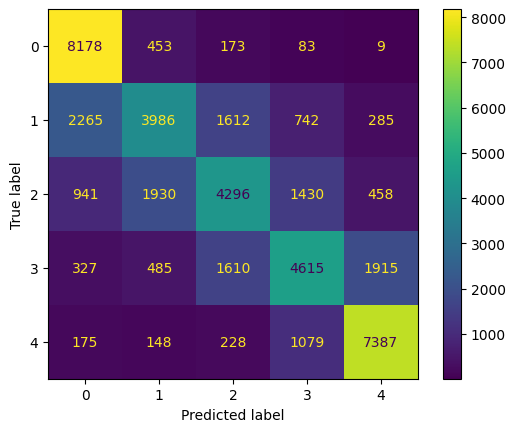

In [25]:
result_model(rfc)

DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      8896
           1       0.43      0.42      0.42      8890
           2       0.42      0.42      0.42      9055
           3       0.46      0.47      0.47      8952
           4       0.66      0.64      0.65      9017

    accuracy                           0.53     44810
   macro avg       0.53      0.53      0.53     44810
weighted avg       0.53      0.53      0.53     44810



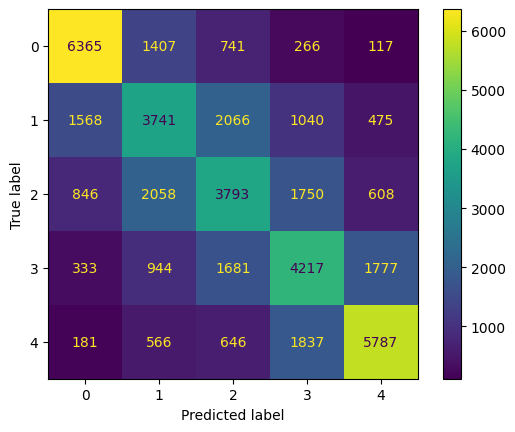

In [26]:
result_model(dfc)

SGDClassifier()
              precision    recall  f1-score   support

           0       0.52      0.96      0.68      8896
           1       0.49      0.24      0.32      8890
           2       0.47      0.15      0.23      9055
           3       0.44      0.27      0.33      8952
           4       0.51      0.89      0.65      9017

    accuracy                           0.50     44810
   macro avg       0.49      0.50      0.44     44810
weighted avg       0.49      0.50      0.44     44810



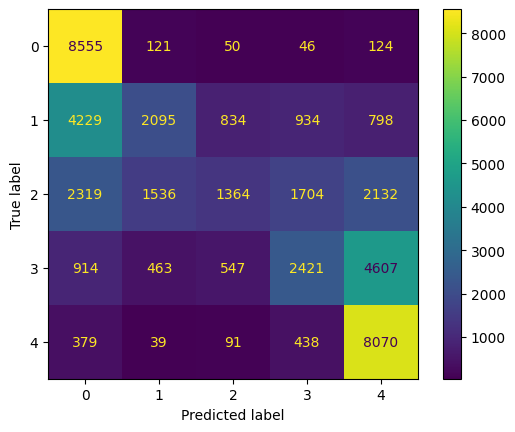

In [29]:
result_model(sgd)

LinearSVC(max_iter=1000000)
              precision    recall  f1-score   support

           0       0.70      0.91      0.79      8896
           1       0.46      0.42      0.44      8890
           2       0.43      0.33      0.37      9055
           3       0.49      0.38      0.43      8952
           4       0.69      0.86      0.77      9017

    accuracy                           0.58     44810
   macro avg       0.56      0.58      0.56     44810
weighted avg       0.56      0.58      0.56     44810



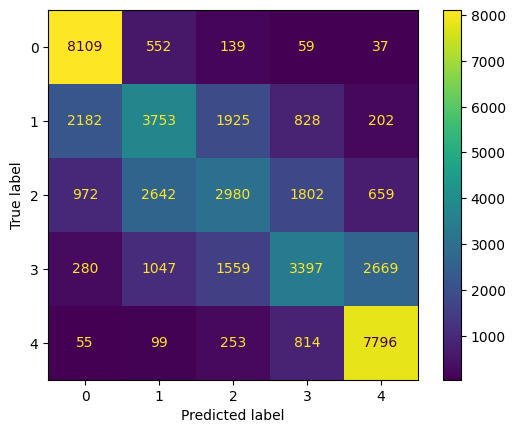

In [30]:
result_model(lsvc)

Perceptron()
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      8896
           1       0.37      0.39      0.38      8890
           2       0.34      0.36      0.35      9055
           3       0.41      0.31      0.35      8952
           4       0.68      0.77      0.72      9017

    accuracy                           0.52     44810
   macro avg       0.51      0.52      0.51     44810
weighted avg       0.51      0.52      0.51     44810



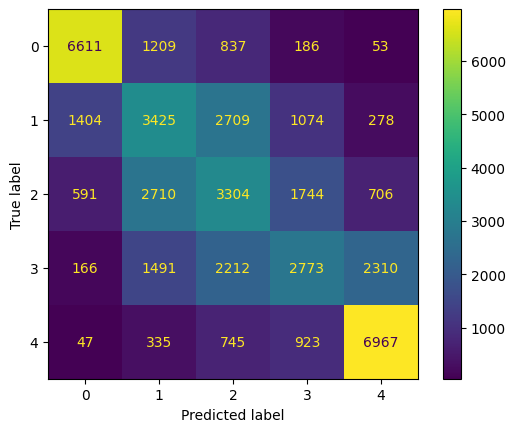

In [31]:
result_model(per)

KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

           0       0.28      0.86      0.43      8896
           1       0.24      0.27      0.25      8890
           2       0.28      0.12      0.17      9055
           3       0.41      0.12      0.18      8952
           4       0.70      0.11      0.19      9017

    accuracy                           0.29     44810
   macro avg       0.38      0.29      0.24     44810
weighted avg       0.38      0.29      0.24     44810



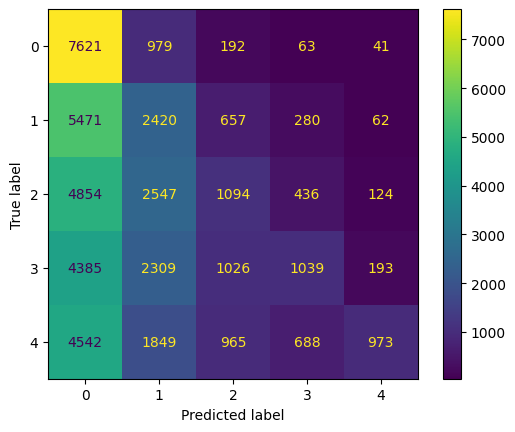

In [21]:
result_model(knc)

LogisticRegression(max_iter=1000000)
              precision    recall  f1-score   support

           0       0.69      0.87      0.77      8896
           1       0.48      0.43      0.45      8890
           2       0.43      0.37      0.40      9055
           3       0.49      0.41      0.44      8952
           4       0.69      0.79      0.74      9017

    accuracy                           0.57     44810
   macro avg       0.56      0.57      0.56     44810
weighted avg       0.55      0.57      0.56     44810



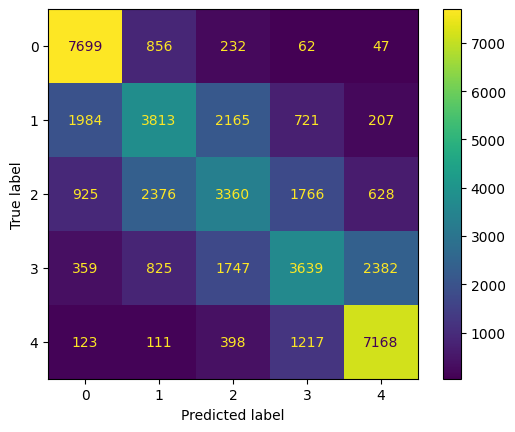

In [33]:
result_model(lr)

In [22]:
dump(rfc, "./database/rfc_mode;.pkl")

['./database/rfc_mode;.pkl']